# Mask R-CNN Image Segmentation
This Kernel uses a Mask R-CNN model that was trained on Cloud TPU to perform instance segmentation on a sample input image. The resulting predictions are overlayed on the sample image as boxes, instance masks, and labels. 

Images of various features including mapping index can be tested by editing the input image URL or uploading an image to your google drive.

### About Mask R-CNN
The Mask R-CNN model addresses one of the most difficult computer vision challenges: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," which means that different instances of the same type of object in the input image, for example, car, should be assigned distinct labels.

Also the Mask R-CNN model builds on the Faster R-CNN model to convert the box cordinates (Regression output) into a Binary Mask 

## Downloading the source code


In [1]:
!git clone https://github.com/zuruoke/mask_cnn/

Cloning into 'tpu'...
remote: Enumerating objects: 8096, done.
remote: Total 8096 (delta 0), reused 0 (delta 0), pack-reused 8096
Receiving objects: 100% (8096/8096), 23.73 MiB | 31.08 MiB/s, done.
Resolving deltas: 100% (5742/5742), done.


## Import libraries

In [2]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

TensorFlow 1.x selected.


## Load the COCO index mapping
This Kernel uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [0]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Loading an image


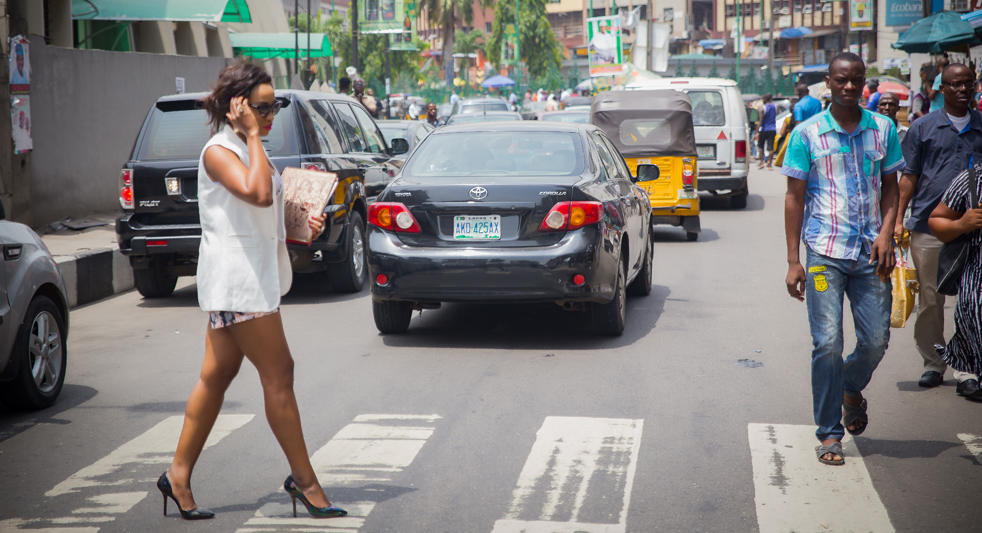

In [4]:
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
image_path = 'dalo.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.
Here, I'll make use of the Google TPU (Tensor Processing Unit)

In [5]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.51.60.90:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 15942614007869234917),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15639600984009279700),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1035896171984230310),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1093671106733275534),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10656821170193062026),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 14688763792861501608),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 11833101039387248495),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14565581048998337484),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 68327153281

# Loading the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [6]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Perform instance segmentation and retrieve the predictions
Now I'll run the inference and process the predictions from the model.


In [0]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

## Visualize the detection results
Time to check out the result!

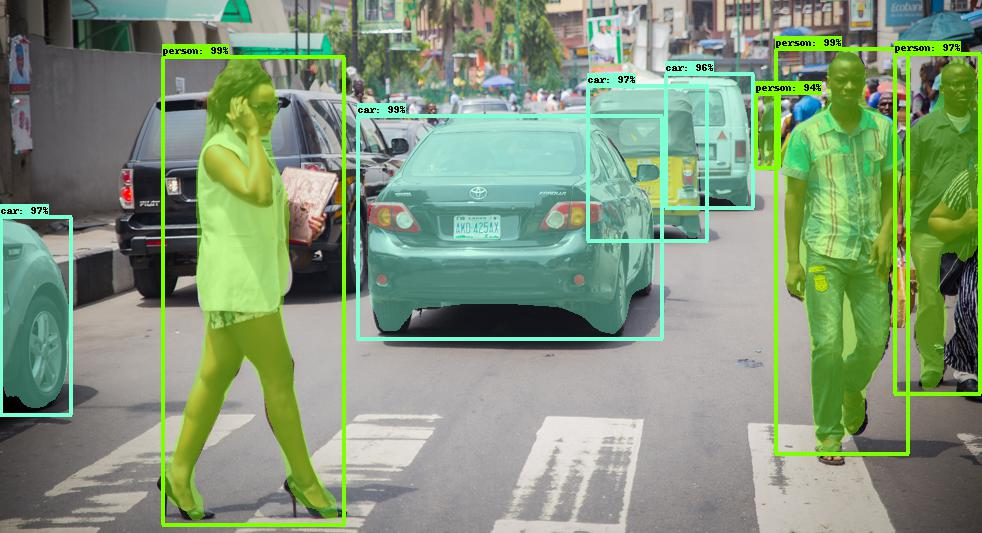

In [8]:
max_boxes_to_draw =    8#@param {type:"integer"}
min_score_thresh = 0.23    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))